# Fun with maps, part 2

After some map images have been picked from random locations in the map service, we can filter out images that are not in the area of interest.

## Dependencies

In [1]:
#r "nuget: SixLabors.ImageSharp"

Installed Packages SixLabors.ImageSharp, 2.1.3

In [2]:
using System.IO;
using SixLabors.ImageSharp;
using SixLabors.ImageSharp.PixelFormats;

using static Microsoft.DotNet.Interactive.Formatting.PocketViewTags;

var random = new Random();

## Step 2: Filter images

Remove _mostly blank_ images. Relevant images will be stored in the `output/step2` folder.

### List of images from Step 1

In [2]:
var sourceImageFolder = "output/step1";

var sourceImages = Directory.GetFiles(sourceImageFolder).Where(file => file.EndsWith("png")).ToList();

display($"{sourceImages.Count} source images found, displaying name of first 10");
display(sourceImages.Take(10));

48 source images found, displaying name of first 10

index,value
0,output/step1/8__65.32437079112131__-27.843458928963436.png
1,output/step1/10__-79.87959970701282__52.86074055347461.png
2,output/step1/7__-44.09199878518183__-10.70419321897623.png
3,output/step1/12__-156.1395963098584__-32.738234294870615.png
4,output/step1/10__-64.55468161335037__-2.9182961324561205.png
5,output/step1/8__170.64838531656648__-67.95677635993266.png
6,output/step1/7__16.61484365251573__65.75746996780518.png
7,output/step1/12__-51.66772028009447__-41.40776112006163.png
8,output/step1/8__-116.12267212017139__-4.6876423730384715.png
9,output/step1/8__147.337666463444__2.2770515275757077.png


### Read pixel values from image

Use the _ImageSharp_ library to read pixel values from image ( [source code](https://github.com/SixLabors/ImageSharp) ).

Other alternatives include _SkiaSharp_ or `System.Drawing.Bitmap`, as suggested in [this article](https://devblogs.microsoft.com/dotnet/net-core-image-processing/).

In [6]:
var someImage = sourceImages.Skip(random.Next(sourceImages.Count)).First();

IEnumerable<Rgba32> GetColors(Image<Rgba32> bitmap)
{
	for (int x = 0; x < bitmap.Width; x++)
	{
		for (int y = 0; y < bitmap.Height; y++)
		{
			yield return bitmap[x, y];
		}
	}
}

(IEnumerable<byte> reds, IEnumerable<byte> greens, IEnumerable<byte> blues) GetColorChannels(IEnumerable<Rgba32> colors)
{
	var list = colors.ToList();
	var reds = list.Select(color => color.R);
	var greens = list.Select(color => color.G);
	var blues = list.Select(color => color.B);

	return (reds, greens, blues);
}

IEnumerable<byte> reds;
IEnumerable<byte> greens;
IEnumerable<byte> blues;

using (var bitmap = Image.Load<Rgba32>(someImage)) {
	(reds, greens, blues) = GetColorChannels(GetColors(bitmap));
}


output/step1/12__-91.97225428923579__2.4031960631099025.png Reds: 146, 146, 146, 146, 146, 146, 146, 146, 146, 146... Blues: 230, 230, 230, 230, 230, 230, 230, 230, 230, 230... Greens: 199, 199, 199, 199, 199, 199, 199, 199, 199, 199...
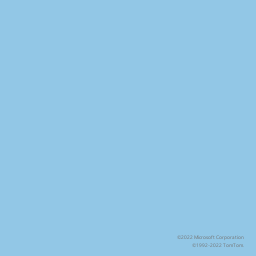

In [7]:
display(
	table(
		caption(someImage),
		tr(
			td[rowspan: 3](img[src: "data:image/png;base64," + Convert.ToBase64String(File.ReadAllBytes(someImage)), width: "50%"]),
			td($"Reds: {string.Join(", ", reds.Take(10))}...")
		),
		tr(
			td($"Blues: {string.Join(", ", blues.Take(10))}...")
		),
		tr(
			td($"Greens: {string.Join(", ", greens.Take(10))}...")
		)
	)
)

### Detect _mostly blank_ images

We can use the standard deviation of all three color channels to detect _mostly blank_ images. Mostly uniform images will have a standard deviation close to 0 for all color channels. This method is not perfect, but has the advantage to handle compression artifacts well (compression can cause small variations on very similar colors).

.NET Core does not come with a standard deviation function, so we use an implementation based on [this approach](https://www.strchr.com/standard_deviation_in_one_pass) and [this StackOverflow](https://stackoverflow.com/a/19370637) answer.

In [8]:
double std_var (byte[] a) {
	if (a.Length == 0) return 0;
	double sum = 0;
	double sq_sum = 0;
	for(int i = 0; i < a.Length; ++i) {
		int ai = a[i];
		sum += ai;
		sq_sum += ai * ai;
	}
	double N = a.Length;
	return (N * sq_sum - sum * sum) / (N * N);
}

Actually it is the variance that is being computed, but this will perfectly do in this case (the standard deviation is the square root of the variance).

Red variance 0.5238069137558341 Blue variance 7.325067147612572 Green variance 3.910941540263593
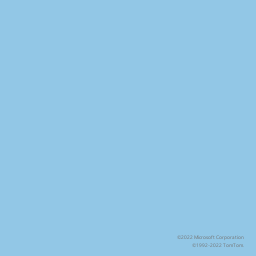

Red variance 564.3996359405573 Blue variance 206.62082151859067 Green variance 332.358406154206
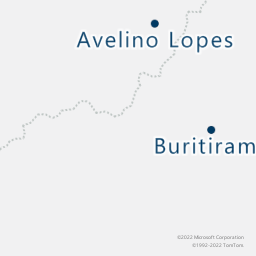

Red variance 74.44604207924567 Blue variance 177.7390734681394 Green variance 40.2507464280352
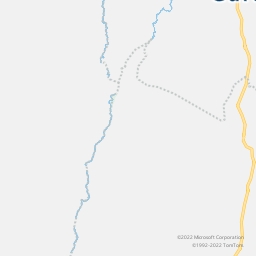

Red variance 0.5238069137558341 Blue variance 7.325067147612572 Green variance 3.910941540263593
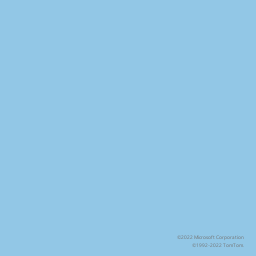

Red variance 161.92358016967773 Blue variance 153.21880346443504 Green variance 144.5286188935861
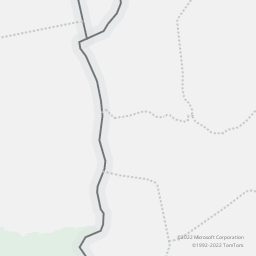

In [10]:
var randomImages = sourceImages.OrderBy(file => random.Next()).Take(5);

var imagesWithVariance = randomImages
	.Select(imageFile => {
		var colorChannels = GetColorChannels(GetColors(Image.Load<Rgba32>(imageFile)));
		return new {
			file = imageFile,
			redVariance = std_var(colorChannels.reds.ToArray()),
			greenVariance = std_var(colorChannels.greens.ToArray()),
			blueVariance = std_var(colorChannels.blues.ToArray())
		};
	});

imagesWithVariance.ToList().ForEach(
	image => display(
		table(
			tr(
				td[rowspan: 3](img[src: "data:image/png;base64," + Convert.ToBase64String(File.ReadAllBytes(image.file)), width: "50%"]),
				td("Red variance"),
				td(image.redVariance)
			),
			tr(
				td("Blue variance"),
				td(image.blueVariance)
			),
			tr(
				td("Green variance"),
				td(image.greenVariance)
			)
		)
	));

### Save filtered images

If all three color channels have a variance below a defined threshold, the image is _mostly blank_ and can be discarded.

The threshold is somewhat arbitrary, but it seems to work well given the source data and considering that
- it is compared against the variance of each channel
- there is a small watermark at the bottom right of each image

In [12]:
var outputImageFolder = "output/step2";
var threshold = 10d;

public bool IsBlank(string imageFile, double threshold) {
	var colorChannels = GetColorChannels(GetColors(Image.Load<Rgba32>(imageFile)));
	return new [] { colorChannels.reds, colorChannels.greens, colorChannels.blues }
		.All(channel => std_var(channel.ToArray()) < threshold);
}

sourceImages
	.Where(imageFile => !IsBlank(imageFile, threshold))
	.ToList()
	.ForEach(
		imageFile => File.Copy(imageFile, Path.Combine(outputImageFolder, Path.GetFileName(imageFile)), overwrite: true)
	);